In [2]:

import warnings
warnings.simplefilter('ignore')

import pickle

import numpy as np  
import pandas as pd  # type: ignore

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as colors

import seaborn as sns


In [14]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"  


In [3]:
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, concatenate, LeakyReLU, Normalization
from keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.losses import categorical_crossentropy

from sklearn.metrics import confusion_matrix


2024-12-17 19:46:20.647449: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 19:46:20.667355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 19:46:20.683447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 19:46:20.688313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 19:46:20.699727: I tensorflow/core/platform/cpu_feature_guar

In [4]:
def preprocess_image(image):
    image = tf.expand_dims(image, -1)  # Adds a third dimension for channels
    # Resize image
    image = tf.image.resize(image, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

In [5]:
num_classes = 4  # Number of classes

In [8]:

radar_4hr_6hr = np.load(f'./radar_refl_4hr_6hr_dataset_Mask_addtime.npz', mmap_mode='r')
X_test = radar_4hr_6hr['X_test']
y_test = radar_4hr_6hr['y_test']

In [9]:
with tf.device("CPU"):
    X_test_F = tf.convert_to_tensor(X_test)
    y_test_F = tf.convert_to_tensor(y_test)

    X_test_FF=preprocess_image(X_test_F)
    y_test_FF=preprocess_image(y_test_F)
    print(y_test_FF.shape)

    y_test_one_hot_F = tf.keras.utils.to_categorical(y_test_FF, num_classes=4)  # Convert to one-hot encoding
    print(X_test_FF.shape,y_test_one_hot_F.shape)


(2153, 128, 128, 1)
(2153, 128, 128, 1) (2153, 128, 128, 4)


In [10]:

def weighted_categorical_crossentropy(weights):
    """A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    """
    weights = tf.constant(weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        # scale predictions so that the class probabilities of each pixel sum to 1
        y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # calculate the weighted loss
        loss = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(loss, -1)
        return loss
    
    return loss

In [11]:
class_weights = [3.42532998, 0.32800352 ,5.42562766 ,2.10526705]  # pre-calculated

In [13]:
# # Let's load the model
custom_loss = weighted_categorical_crossentropy(class_weights)
from tensorflow.keras.models import load_model
model = load_model('./v1_best_model_bs16_dropout_GridSearch.keras', custom_objects={'loss': custom_loss})



# Evaluation 

In [17]:
# Make predictions on the selected validation image
y_pred = model.predict(X_test_FF)
print(y_pred.shape)

# Assuming the predictions are probabilities, convert to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)
y_test_labels = np.argmax(y_test_one_hot_F, axis=-1)

I0000 00:00:1734482992.822694    1139 service.cc:146] XLA service 0x7fec200415d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734482992.822725    1139 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-12-17 19:49:52.842702: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734482993.308774    1139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step
(2153, 128, 128, 4)


# Pixel Level Evaluation 

In [30]:
def plot_confusion_matrix(y_true, y_pred, num_classes=4):
    y_true = np.argmax(y_true.reshape(-1, num_classes), axis=1)
    y_pred = np.argmax(y_pred.reshape(-1, num_classes), axis=1)
    conf_mat = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [31]:
# Convert the EagerTensor to a NumPy array
true_labels_np = y_test_one_hot_F.numpy().reshape(-1, 4)

# Compute the argmax to get the true labels
true_labels = np.argmax(true_labels_np, axis=1)

# If you have predicted labels in the same format:
predicted_labels = y_pred_labels.flatten()  # Convert to NumPy if needed


In [32]:

num_images, num_time, num_height = y_pred_labels.shape

# Initialize y_pred_labels_post with the same shape
y_pred_labels_post = np.copy(y_pred_labels)

# Iterate through each image and time slice
for i in range(num_images):
    for t in range(num_time):
        column = y_pred_labels[i, t, :]
        mask_not_one = column != 1
        values_not_one = column[mask_not_one]
        if values_not_one.size > 0:
            counts = np.bincount(values_not_one, minlength=4)  # Ensure there are counts for 0 to 3
            counts[1] = -1  # Ignore occurrences of 1 by setting its count to -1
            most_frequent = np.argmax(counts)
            y_pred_labels_post[i, t, mask_not_one] = most_frequent
            

# Transform 3-d y_pred_labels_post to 2-d (cases, time).

In [36]:
def process_column(column):
    unique_vals = np.unique(column)
    if len(unique_vals) == 1:
        return unique_vals[0]  # Return this single value
    elif len(unique_vals) == 2 and np.all(np.isin([0, 1], unique_vals)):
        return 0  # Return 0 if only 0 and 1 are present
    elif 2 in unique_vals:
        return 2  # Return 2 if 2 is one of the unique values
    elif 3 in unique_vals:
        return 3  # Return 3 if 3 is one of the unique values
    return np.nan  # Default 

In [34]:
y_pred_labels_1d = np.apply_along_axis(process_column, 2, y_pred_labels_post)
true_labels_1d = np.apply_along_axis(process_column, 2, y_test_labels)
y_pred_labels_1d.shape,true_labels_1d.shape

((2153, 128), (2153, 128))

[0 1 2 3]
[1 2 3]


Text(0.5, 47.7222222222222, 'Predicted Label')

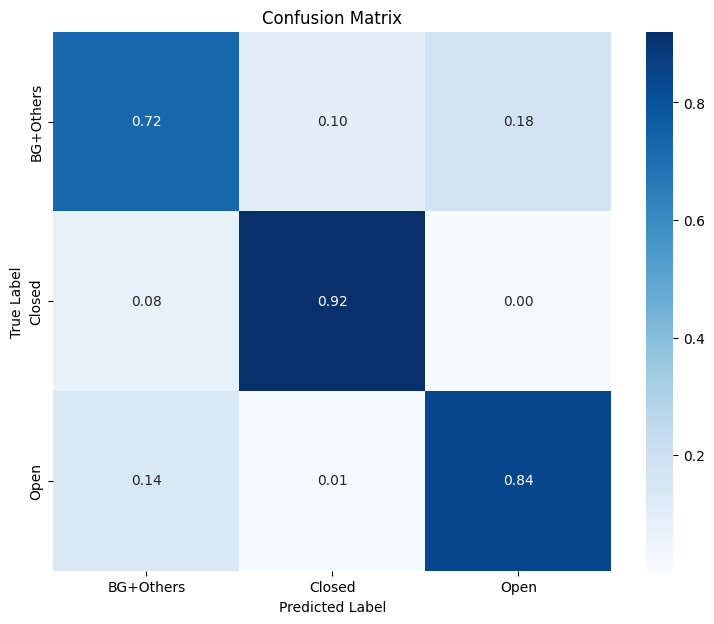

In [35]:

print(np.unique(y_pred_labels_1d))
true_labels_1d[true_labels_1d==0]=1.
y_pred_labels_1d[y_pred_labels_1d==0]=1.
print(np.unique(true_labels_1d))

cm_post = confusion_matrix(true_labels_1d[(true_labels_1d>=0)& (y_pred_labels_1d>=0)], y_pred_labels_1d[(true_labels_1d>=0)& (y_pred_labels_1d>=0)], normalize='true')

filtered_cm = cm_post[np.ix_([0, 1, 2], [0, 1, 2])]

# Define the classes you want to include in the plot
classes_filtered = ['BG+Others', 'Closed', 'Open']

# Plotting the filtered confusion matrix
plt.figure(figsize=(9, 7))
sns.heatmap(filtered_cm, annot=True, fmt='.2f', xticklabels=classes_filtered, yticklabels=classes_filtered, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


# Newly added

In [29]:
def plot_image_with_intensity_colorbar(img0, title,start_time):
    """
    Plots an image with a colorbar indicating intensity values.
    """

    img = np.transpose(img0)
    img_plot = plt.imshow(img, cmap='jet', vmin=0, vmax=1, origin='lower', aspect='auto')
    plt.colorbar(img_plot, orientation='vertical')
    plt.title(title)
    
    # Set custom ticks and labels for axes
    plt.xlabel('Time (Hour)')
    plt.ylabel('Height (km)')
    time_ticks = np.linspace(0, img.shape[1] - 1, 5)  # Assuming 4-hour range
    plt.xticks(time_ticks, labels=np.linspace(start_time-2, start_time+2, 5))
    height_ticks = np.linspace(0, img.shape[0] - 1, 4)  # Assuming 3-km range
    plt.yticks(height_ticks, labels=np.linspace(start_time-2, start_time+1, 4))



def plot_mask_with_colorbar(mask0, title, classes, colors,start_time):
    """
    Plots a mask with a colorbar indicating classes.
    """

    mask = np.transpose(mask0)

    cmap = mcolors.ListedColormap(colors)
    bounds = list(range(len(classes) + 1))
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    mask_plot = plt.imshow(mask, cmap=cmap, norm=norm, origin='lower', aspect='auto')
    
    # Set custom ticks and labels for axes
    plt.xlabel('Time (Hour)')
    plt.ylabel('Height (km)')
    time_ticks = np.linspace(0, mask.shape[1] - 1, 5)  # Assuming 4-hour range
    plt.xticks(time_ticks, labels=np.linspace(start_time-2, start_time+2, 5))
    height_ticks = np.linspace(0, mask.shape[0] - 1, 4)  # Assuming 3-km range
    plt.yticks(height_ticks, labels=np.linspace(start_time-2, start_time+1, 4))
    
    # Calculate middle points for ticks
    middle_points = [x + 0.5 for x in range(len(classes))]
    
    cbar = plt.colorbar(mask_plot, ticks=middle_points)
    cbar.ax.set_yticklabels(classes)
    plt.title(title)


def visualize_prediction_compare(x_val, y_true, y_pred, y_pred_post, index):
    """
    Visualizes a single example from the validation set, its true labels, and the predicted mask.
    """
    classes = ['Others', 'BG', 'Closed', 'Open']
    colors = ['black', 'white', 'red', 'blue']

    fig, axs = plt.subplots(1, 3, figsize=(32, 6))
    
    plt.sca(axs[0])
    plot_image_with_intensity_colorbar(x_val[index, ..., 0], "(a) Normalized Radar Reflectivity",2)
    
    plt.sca(axs[1])
    plot_mask_with_colorbar(y_true[index], "(b) Manual Mask", classes, colors,2)
    
    plt.sca(axs[2])
    plot_mask_with_colorbar(y_pred[index], "(c) Predicted Mask", classes, colors,2)




# Examples

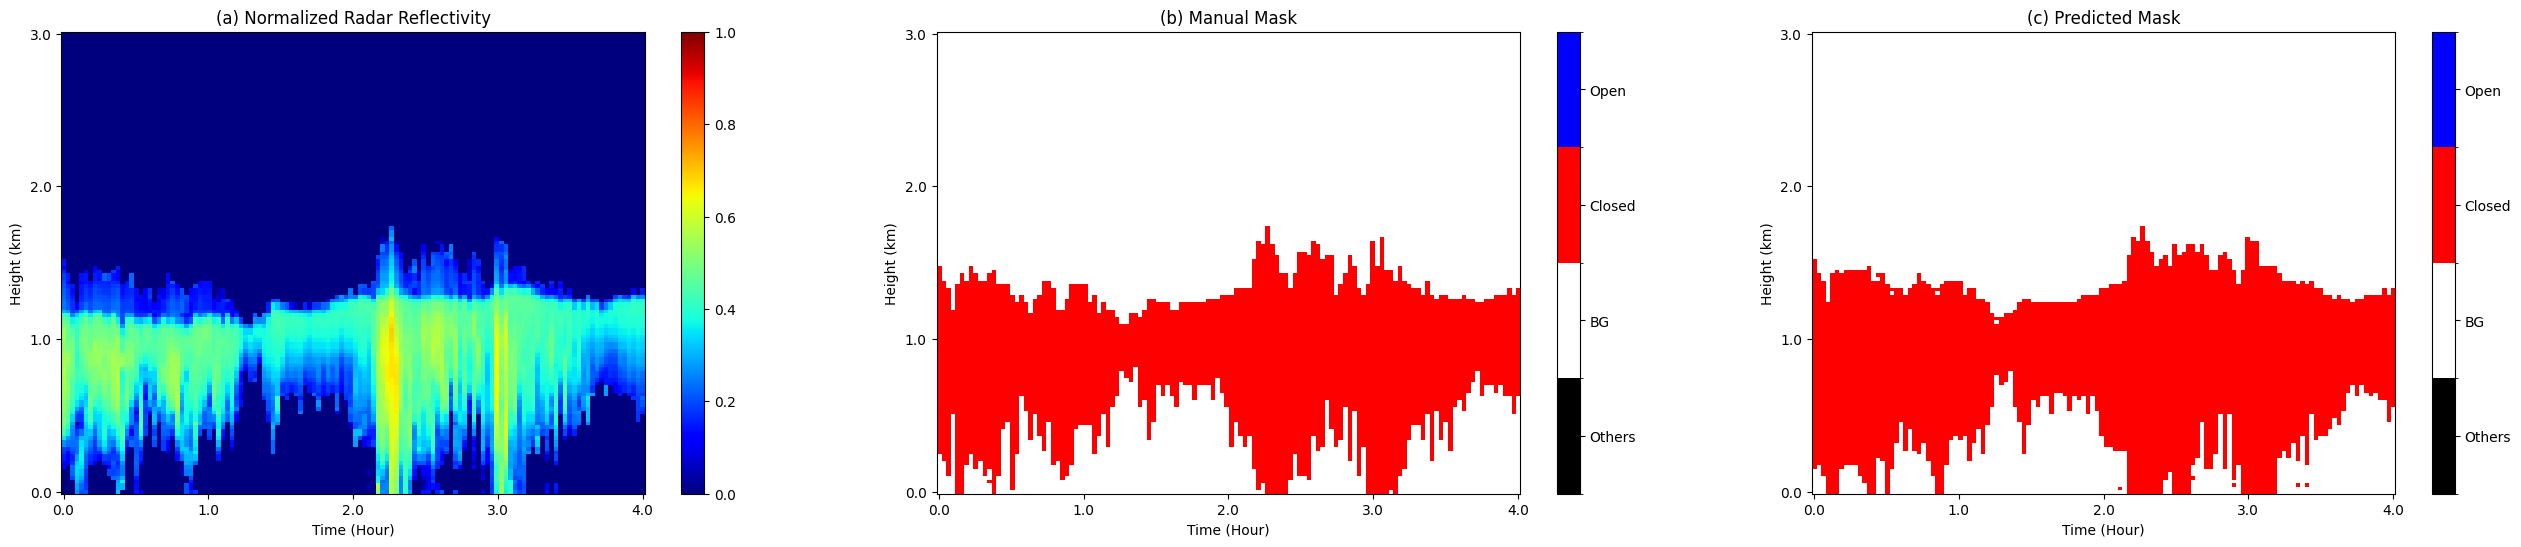

In [26]:
index = 1200
visualize_prediction_compare(X_test_FF, y_test_labels,y_pred_labels_post, y_pred_labels, index)


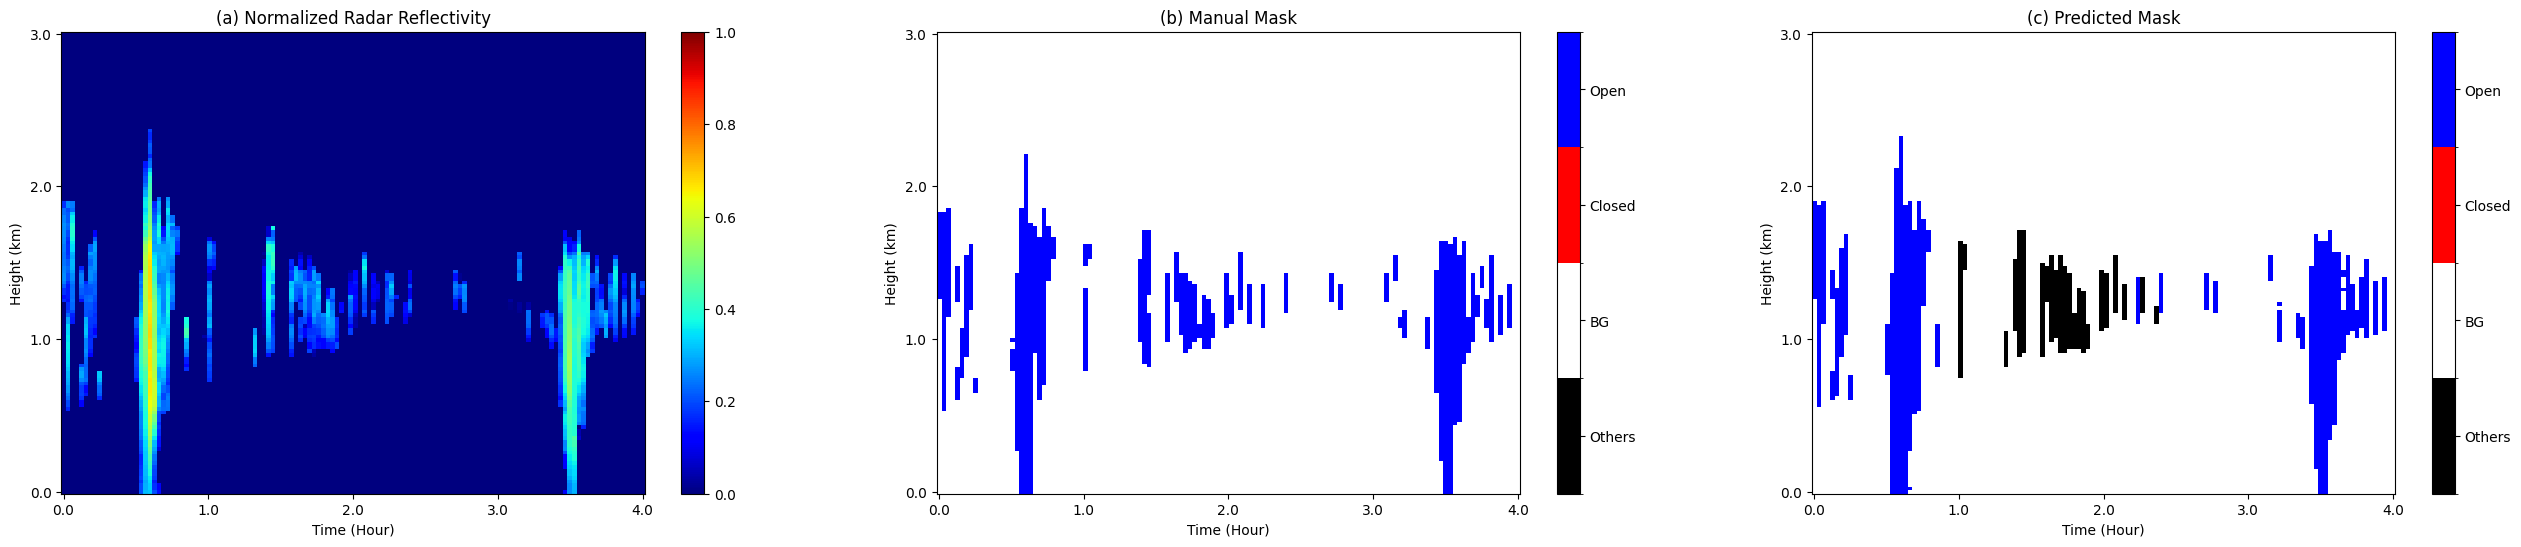

In [27]:
index = 1474

visualize_prediction_compare(X_test_FF, y_test_labels,y_pred_labels_post, y_pred_labels, index)

